In [1]:
def normalize(x):
    maxs = max([max(i[:-1]) for i in x])
    mins = min([min(i[:-1]) for i in x])
    x = list(map(lambda t: list(map(lambda r: (r - mins) / (maxs - mins), t)), x))
    return x, mins, maxs

def inverse_normalization(a, mins, maxs):
    r = a.copy()
    for i in range(len(r) - 1):
        r[i] /= maxs - mins
    r[-1] -= sum([mins * r[i] for i in range(len(r) - 1)])
    return r

def add_ones(x):
    return list(map(lambda t: t + [1], x))

### stochastic gradient descent with momentum

In [2]:
from random import random

def nrmse(x, y, w, diff):
    diffs = [(sum([w[z] * x[i][z] for z in range(len(x[0]))]) - y[i]) ** 2 for i in range(len(x))]
    return sum(diffs) ** 0.5 / diff

# linear regression: stochastic gradient descent with momentum
def sgdm(train, train_result, test, test_result, epochs=1000, lr=1e-2, gamma=0.9, step=10):
    objects = len(train)
    features = len(train[0]) + 1
    
    full = train + test
    normal, mins, maxs = normalize(full)
    train = add_ones(normal[:objects])
    test = add_ones(normal[objects:])
    
    train_measures = []
    test_measures = []
    w = [0] * features
    momentum = [0] * features

    for epoch in range(epochs):
        if (epoch % step == 0):
            train_measures.append(nrmse(train, train_result, w, maxs - mins))
            test_measures.append(nrmse(test, test_result, w, maxs - mins))
        
        i = int(random() * objects)
        diff = sum([w[z] * train[i][z] for z in range(features)]) - train_result[i]
        grad = [diff * train[i][j] for j in range(features)]

        momentum = [momentum[j] * gamma + lr * grad[j] for j in range(features)]
        w = [w[j] - momentum[j] for j in range(features)]

    return (inverse_normalization(w, mins, maxs), train_measures, test_measures)

### pseudo inverse matrix

In [3]:
import numpy as np

def pseudomatrix(x, y):
    return np.matmul(np.linalg.pinv(x), y)

### testing

processing "1.txt"... 8.655098089356917 0.0014045728991042773
processing "2.txt"... 4.338633129679309 0.00011193149824804236
processing "3.txt"... 12.451373693623765 0.016997491104175495
processing "4.txt"... 4.960867531150937 0.002238644053088712
processing "5.txt"... 2.8798421411489517 1.6005517242056824e-06
processing "6.txt"... 1.0397810519726953 0.015117309125840219
processing "7.txt"... 1.0478894870829973 0.1237218652531673
it took 23:03


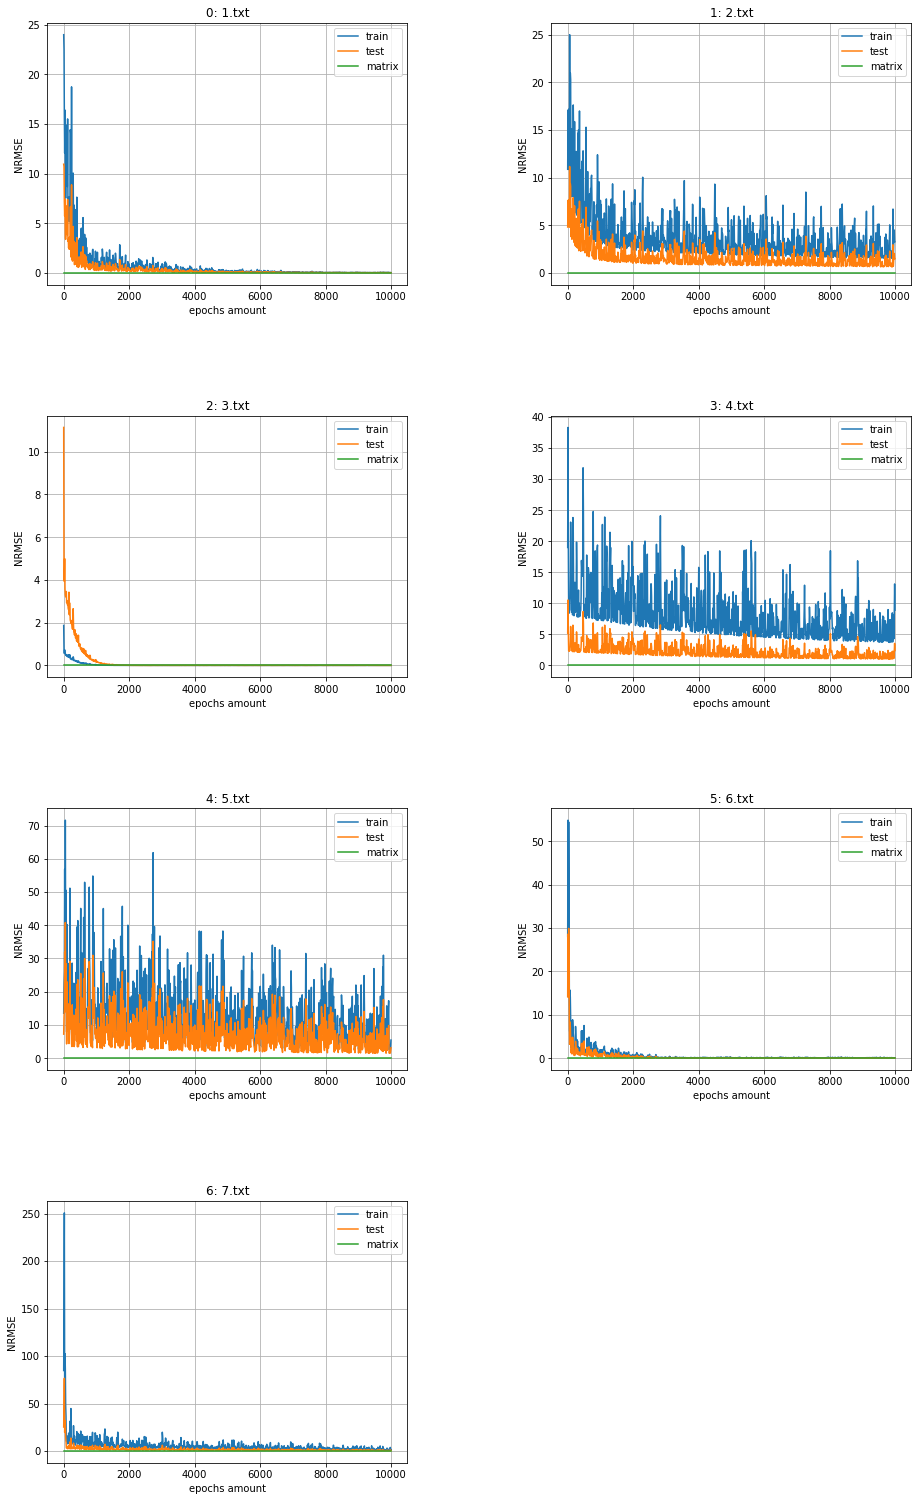

In [4]:
from os import listdir
from os.path import join
from time import time
from math import ceil
import matplotlib.pyplot as plt

def read_objects(amount):
    objects = []
    results = []
    
    for i in range(amount):
        line = list(map(int, file.readline().split()))
        objects.append(line[:-1])
        results.append(line[-1])
        
    return (objects, results)


test_directory = 'test'
files = sorted(listdir(test_directory))

ep = 10000
st = 10
x = list(range(0, ep, st))
ncols = 2
nrows = ceil(len(files) / ncols)
plt.figure()
stopwatch = time()

for i, file_name in zip(range(len(files)), files):
    print('processing "{}"...'.format(file_name), end=' ')
    
    with open(join(test_directory, file_name)) as file:
        features = int(file.readline())
        train_size = int(file.readline())
        train, train_result = read_objects(train_size)
        
        test_size = int(file.readline())
        test, test_result = read_objects(test_size)
        
    grad_result, train_measures, test_measures = sgdm(train, train_result, test, test_result, 
                                                      epochs=ep, step = st)
    matrix_result = pseudomatrix(train, train_result)
    
    maxs = max([max(i) for i in train])
    mins = min([min(i) for i in train])
    
    grad_nrmse = nrmse(test, test_result, grad_result, maxs - mins)
    matrix_nrmse = nrmse(test, test_result, matrix_result, maxs - mins)
    
    print('{} {}'.format(grad_nrmse, matrix_nrmse))
    
    plt.subplot(nrows, ncols, i + 1)
    plt.title('{}: {}'.format(i, file_name))
    plt.ylabel('NRMSE')
    plt.xlabel('epochs amount')
    plt.plot(x, train_measures, label='train')
    plt.plot(x, test_measures, label='test')
    plt.plot(x, [matrix_nrmse] * len(x), label='matrix')
    plt.legend()
    plt.grid(True)

took = time() - stopwatch
print('it took {:02d}:{:02d}'.format(int(took / 60), int(took % 60)))
plt.subplots_adjust(top=5, bottom=0, left=0, right=2, hspace=0.5, wspace=0.4)
plt.show()